In [8]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import joblib

In [2]:
# Function to load data from dir structure
def loadDataFromDir(rootDir):
    data = {'text': [], 'label': []}
    labels = os.listdir(rootDir)

    for label in labels:
        label_path = os.path.join(rootDir, label)
        if os.path.isdir(label_path):
            files = os.listdir(label_path)
            for file in files:
                file_path = os.path.join(label_path, file)
                if "item" not in file_path.split("/")[-1]: continue
                if os.path.isfile(file_path):
                    with open(file_path, 'r', encoding='utf-8') as f:
                        text = f.read()
                        data['text'].append(text)
                        data['label'].append(label.split(" ")[0])

    return data

# Load data from your folder structure
rootDir = '../data/guideline_data'
dataset = loadDataFromDir(rootDir)

In [3]:
# Convert to dataframe
df = pd.DataFrame(dataset)

X_train, X_test, y_train, y_test = train_test_split(df['text'], df['label'], test_size=0.2, random_state=42)

In [4]:
# Create a pipeline with a CountVectorizer and Multinomial Naive Bayes classifier
model = Pipeline([
     ('vect', CountVectorizer()),
     ('tfidf', TfidfTransformer()),
     ('clf', BernoulliNB()),
 ])

In [5]:
# Define the parameter grid
param_grid = {
    'vect__ngram_range': [(1, 1), (1, 2)],
    'tfidf__use_idf': (True, False),
    'clf__alpha': [1e-2, 1e-3, 1e-4]
}

# Perform grid search with cross-validation
grid_search = GridSearchCV(model, param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Print the best parameters and the corresponding accuracy
print("Best parameters found:")
print(grid_search.best_params_)
print(f"Best accuracy: {grid_search.best_score_:.2f}")

# Use the best model for predictions
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

Best parameters found:
{'clf__alpha': 0.0001, 'tfidf__use_idf': True, 'vect__ngram_range': (1, 2)}
Best accuracy: 0.69


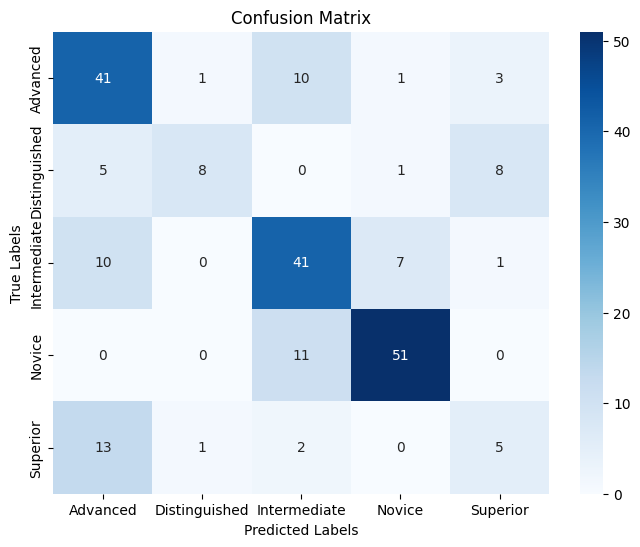

In [6]:
conf_mat = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=best_model.classes_, yticklabels=best_model.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

This matrix seems fine to me, higher levels are hard to distinguise from each other so I'll not be too woried about that.

In [10]:
joblib.dump(best_model, '../trained_models/proficiency_classifier.joblib')

['../trained_models/proficiency_classifier.joblib']

Testing the model

In [11]:
modelPath = "..//trained_models/proficiency_classifier.joblib"
model = joblib.load(modelPath)

testingTexts = [
    "Hola, me llamo Juan. Soy de México.", 
    "Creo que deberíamos considerar todos los aspectos antes de tomar una decisión.",
    "Me resulta más fácil leer noticias en español que libros académicos debido al vocabulario más cotidiano que suelen utilizar."
]

predictedLabels = model.predict(testingTexts)

for text, label in zip(testingTexts, predictedLabels):
    print(f"Text: {text} -> Predicted Label: {label}")

Text: Hola, me llamo Juan. Soy de México. -> Predicted Label: Novice
Text: Creo que deberíamos considerar todos los aspectos antes de tomar una decisión. -> Predicted Label: Advanced
Text: Me resulta más fácil leer noticias en español que libros académicos debido al vocabulario más cotidiano que suelen utilizar. -> Predicted Label: Intermediate


Very correct :)